<a href="https://colab.research.google.com/github/Subh37106/Code-Gen-From-UDB-to-Implementations/blob/main/Case_study_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# 1. Environment Setup and Data Generation
# Since we are simulating the "Fundamental Diagram" seen in the image, we create a synthetic dataset where Speed, Flow, and Occupancy follow the three distinct regimes.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

np.random.seed(42)

free_flow = {
    'speed': np.random.normal(100, 5, 100),
    'flow': np.random.uniform(200, 1400, 100),
    'occupancy': np.random.uniform(5, 15, 100)
}

synchronized = {
    'speed': np.random.normal(70, 8, 100),
    'flow': np.random.uniform(1600, 2300, 100),
    'occupancy': np.random.uniform(15, 35, 100)
}

congested = {
    'speed': np.linspace(5, 35, 100) + np.random.normal(0, 3, 100),
    'flow': np.linspace(100, 1300, 100) + np.random.normal(0, 50, 100),
    'occupancy': np.random.uniform(40, 85, 100)
}

data = pd.DataFrame({
    'speed': np.concatenate([free_flow['speed'], synchronized['speed'], congested['speed']]),
    'flow': np.concatenate([free_flow['flow'], synchronized['flow'], congested['flow']]),
    'occupancy': np.concatenate([free_flow['occupancy'], synchronized['occupancy'], congested['occupancy']])
})

data['variance'] = np.random.uniform(1, 10, 300)
data.head()

,speed,flow,occupancy,variance
0,102.483571,700.893204,12.948113,8.259050
1,99.308678,466.529373,10.026371,6.929050
2,103.238443,343.838441,10.769039,7.230489
3,107.615149,605.138206,9.925177,8.642761
4,98.829233,1331.491645,6.952430,3.247012


In [18]:
# 2. Preprocessing: Z-Score StandardizationAs the UI notes, Speed (0-120) and Occupancy (0-1 or 0-100) have vastly different scales. Without scaling, the Flow rate (reaching 2500) would dominate the distance calculations in K-Means.

In [19]:
features = ['speed', 'flow', 'occupancy', 'variance']
X = data[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

df_scaled = pd.DataFrame(X_scaled, columns=features)
print("Standardized Feature Vector (First 5 rows):")
print(df_scaled.head())

Standardized Feature Vector (First 5 rows):
      speed      flow  occupancy  variance
0  1.166312 -0.687875  -0.813217  0.967205
1  1.072397 -1.038895  -0.938805  0.478706
2  1.188641 -1.222656  -0.906882  0.589422
3  1.318106 -0.831292  -0.943154  1.108138
4  1.058215  0.256608  -1.070935 -0.873676


In [20]:
# 3. Determining K: The Elbow MethodBefore assuming $K=3$, we mathematically verify the optimal number of clusters by plotting the Within-Cluster Sum of Squares (WCSS).

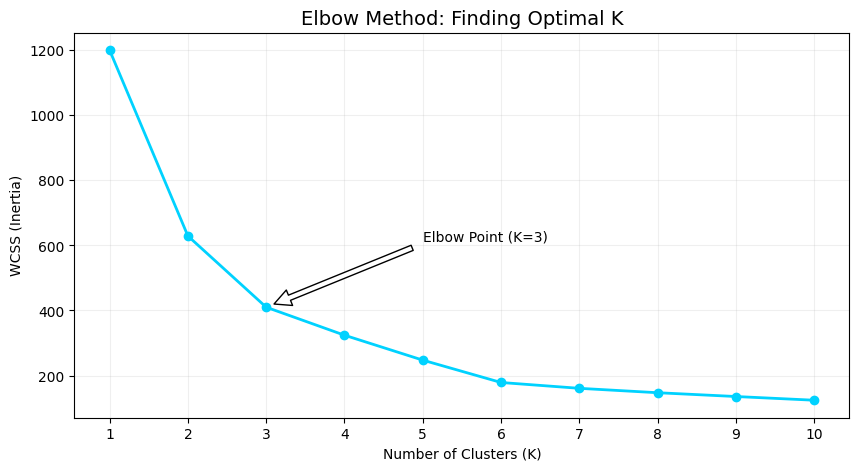

In [21]:
wcss = []
k_range = range(1, 11)

for k in k_range:
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    km.fit(X_scaled)
    wcss.append(km.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(k_range, wcss, marker='o', color='#00d2ff', linewidth=2)
plt.title('Elbow Method: Finding Optimal K', fontsize=14)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(k_range)
plt.grid(alpha=0.2)
plt.annotate('Elbow Point (K=3)', xy=(3, wcss[2]), xytext=(5, wcss[2]*1.5),
             arrowprops=dict(facecolor='white', shrink=0.05))
plt.show()

In [22]:
# 4. Clustering and Regime LabelingWe apply K-Means with K=3 and map the numeric clusters to the human-readable labels: Free Flow, Synchronized, and Congested.

In [23]:
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=42)
data['cluster_id'] = kmeans.fit_predict(X_scaled)

speed_means = data.groupby('cluster_id')['speed'].mean().sort_values(ascending=False)

label_map = {
    speed_means.index[0]: 'Free Flow',
    speed_means.index[1]: 'Synchronized',
    speed_means.index[2]: 'Congested'
}

data['traffic_state'] = data['cluster_id'].map(label_map)

score = silhouette_score(X_scaled, data['cluster_id'])
print(f"Silhouette Score: {score:.4f} (High value indicates distinct traffic states)")

Silhouette Score: 0.4568 (High value indicates distinct traffic states)


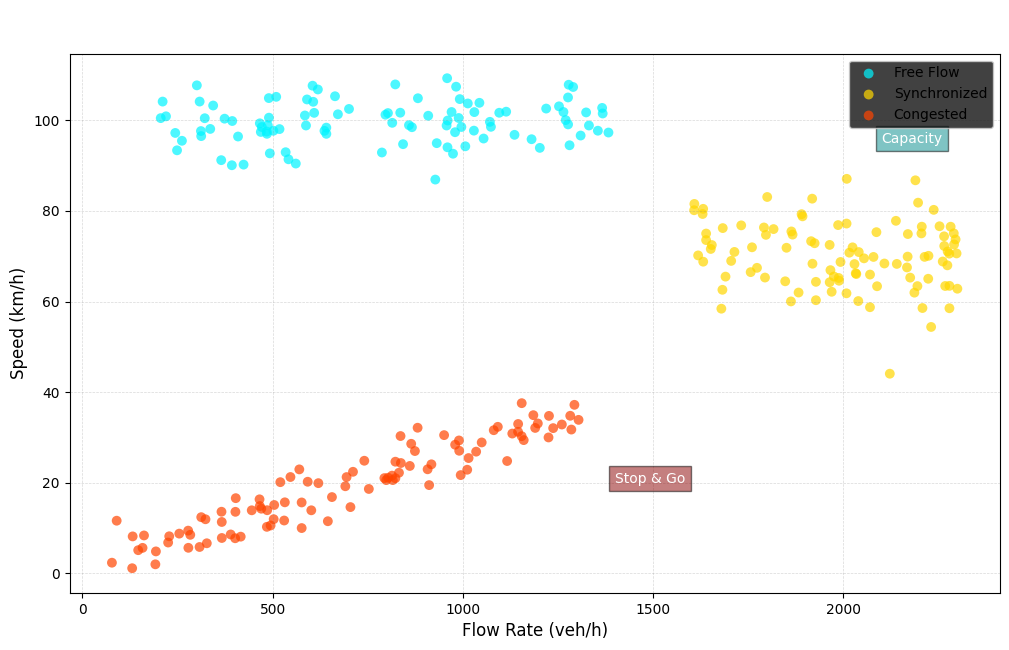

In [24]:
plt.figure(figsize=(12, 7))

colors = {'Free Flow': '#00F5FF', 'Synchronized': '#FFD700', 'Congested': '#FF4500'}

for state, color in colors.items():
    subset = data[data['traffic_state'] == state]
    plt.scatter(subset['flow'], subset['speed'], c=color, label=state, alpha=0.7, s=50, edgecolors='none')

plt.title('Traffic State Recognition: Application Case Study 01', loc='left', fontsize=16, color='white', pad=20)
plt.xlabel('Flow Rate (veh/h)', fontsize=12)
plt.ylabel('Speed (km/h)', fontsize=12)
plt.legend(loc='upper right', frameon=True, facecolor='#121212')

plt.text(2100, 95, 'Capacity', color='white', bbox=dict(facecolor='#008b8b', alpha=0.5))
plt.text(1400, 20, 'Stop & Go', color='white', bbox=dict(facecolor='#8b0000', alpha=0.5))

plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
plt.show()

In [25]:
# Summary of Results
# Preprocessing: Z-score normalization balanced features with different orders of magnitude.
# K Selection: The Elbow Method confirmed $K=3$ is where the marginal gain in data explanation levels off.
# Outcome: We successfully partitioned raw sensor data into three distinct phases: High-speed (Free Flow), High-volume (Synchronized), and Low-speed (Congested)